<a href="https://colab.research.google.com/github/TimoWijnen2001/JBG060_G13/blob/main/dataloader_example_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Reef Support — SEAVIEW_ATL DataLoader (PyTorch)

This Colab notebook mounts Google Drive and constructs a **PyTorch Dataset + DataLoader** for the Reef Support dataset located at:

`/content/drive/MyDrive/benthic_datasets/mask_labels/reef_support/SEAVIEW_ATL`

It expects the following folder structure (typical for past exports):

```
SEAVIEW_ATL/
├── images/                # original RGB images (various extensions)
├── masks/                 # multiple single-class color masks per image (optional for this loader)
└── masks_stitched/        # one color mask per image, with suffix "_mask.png"
```

**Matching rule:** an image named `foo.jpg` should have a stitched mask named `foo_mask.png` inside `masks_stitched/`.


## 1) Setup & Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Change ROOT_DIR to the location where you have short cutted the dataset to
ROOT_DIR = "/content/drive/MyDrive/Data Challenge 3 - JBG060 AY2526/01_data/benthic_datasets/mask_labels/reef_support/SEAVIEW_ATL"
IMAGES_DIR = f"{ROOT_DIR}/images"
MASKS_STITCHED_DIR = f"{ROOT_DIR}/masks_stitched"  # required by this loader
MASKS_DIR = f"{ROOT_DIR}/masks"                     # optional

import os
assert os.path.isdir(IMAGES_DIR), f"Images folder not found: {IMAGES_DIR}"
assert os.path.isdir(MASKS_STITCHED_DIR), f"Stitched masks folder not found: {MASKS_STITCHED_DIR}"

print('Images:', IMAGES_DIR)
print('Masks (stitched):', MASKS_STITCHED_DIR)
print('Masks (single, optional):', os.path.isdir(MASKS_DIR) and MASKS_DIR)

Images: /content/drive/MyDrive/Data Challenge 3 - JBG060 AY2526/01_data/benthic_datasets/mask_labels/reef_support/SEAVIEW_ATL/images
Masks (stitched): /content/drive/MyDrive/Data Challenge 3 - JBG060 AY2526/01_data/benthic_datasets/mask_labels/reef_support/SEAVIEW_ATL/masks_stitched
Masks (single, optional): /content/drive/MyDrive/Data Challenge 3 - JBG060 AY2526/01_data/benthic_datasets/mask_labels/reef_support/SEAVIEW_ATL/masks


## 2) Install dependencies

In [ ]:
!pip -q install torch torchvision pillow tqdm

## 3) Imports

In [ ]:
import os
from glob import glob
from typing import List, Tuple, Optional, Dict

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from tqdm import tqdm

# Utilities for visualization
import matplotlib.pyplot as plt

## 4) Scan dataset & basic sanity checks

In [ ]:
def list_images(images_dir: str, exts=('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')) -> List[str]:
    files = []
    for e in exts:
        files.extend(glob(os.path.join(images_dir, f"*{e}")))
    return sorted(files)

def infer_mask_path(img_path: str, masks_stitched_dir: str) -> Optional[str]:
    base = os.path.splitext(os.path.basename(img_path))[0]
    mask_name = f"{base}_mask.png"
    cand = os.path.join(masks_stitched_dir, mask_name)
    return cand if os.path.isfile(cand) else None

all_images = list_images(IMAGES_DIR)
print(f"Found {len(all_images)} images")

paired = 0
unpaired_examples = []
for p in all_images[:1000]:  # quick sample check
    m = infer_mask_path(p, MASKS_STITCHED_DIR)
    if m is not None:
        paired += 1
    else:
        if len(unpaired_examples) < 10:
            unpaired_examples.append(p)

print(f"Sample check — stitched mask pairs found: {paired}/{min(len(all_images),1000)}")
if unpaired_examples:
    print("Examples lacking stitched masks (first 10):")
    for u in unpaired_examples:
        print(" -", os.path.basename(u))

Found 659 images
Sample check — stitched mask pairs found: 659/659


## 5) PyTorch Dataset

In [ ]:
class ReefSegDataset(Dataset):
    """Dataset that returns (image_tensor, mask_tensor, meta).

    - Images are loaded as RGB and transformed to float tensors [0,1].
    - Stitched masks are loaded as RGB color masks (uint8). By default we return them as tensors [0..255].
      If you have a color->class mapping, you can plug in a converter to map colors to class indices.
    """
    def __init__(
        self,
        images_dir: str,
        masks_stitched_dir: str,
        resize: Optional[Tuple[int, int]] = None,   # e.g., (512, 512)
        image_transform: Optional[T.Compose] = None,
        mask_transform: Optional[T.Compose] = None,
        return_paths: bool = False,
        drop_unpaired: bool = True,
    ):
        self.images_dir = images_dir
        self.masks_stitched_dir = masks_stitched_dir
        self.resize = resize
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.return_paths = return_paths

        images = list_images(images_dir)
        pairs = []
        misses = 0
        for img in images:
            m = infer_mask_path(img, masks_stitched_dir)
            if m is None:
                misses += 1
                if not drop_unpaired:
                    pairs.append((img, None))
            else:
                pairs.append((img, m))

        self.pairs = pairs
        print(f"Dataset init — total images: {len(images)}, usable pairs: {len(self.pairs)}, missing stitched masks: {misses}")

        # Default image_transform if none provided
        if self.image_transform is None:
            tfms = [T.ToTensor()]  # converts PIL to [0,1] float tensor CHW
            if self.resize is not None:
                tfms.insert(0, T.Resize(self.resize, antialias=True))
            self.image_transform = T.Compose(tfms)

        # Default mask_transform: keep as tensor with values [0..255]
        if self.mask_transform is None:
            tfms_m = []
            if self.resize is not None:
                tfms_m.append(T.Resize(self.resize, interpolation=T.InterpolationMode.NEAREST))
            tfms_m.append(T.PILToTensor())  # uint8 CxHxW
            self.mask_transform = T.Compose(tfms_m)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx: int):
        img_path, mask_path = self.pairs[idx]

        # Load image
        img = Image.open(img_path).convert('RGB')

        # Load mask (stitched color mask)
        if mask_path is not None and os.path.isfile(mask_path):
            mask = Image.open(mask_path).convert('RGB')
        else:
            # create an empty mask if missing
            mask = Image.fromarray(np.zeros((img.height, img.width, 3), dtype=np.uint8))

        # Apply transforms
        img_t = self.image_transform(img) if self.image_transform else img
        mask_t = self.mask_transform(mask) if self.mask_transform else mask

        meta = {
            "image_path": img_path,
            "mask_path": mask_path
        }

        if self.return_paths:
            return img_t, mask_t, meta
        else:
            return img_t, mask_t


### (Optional) Convert color masks to class index masks

If your stitched masks use **specific colors per class**, define a mapping from RGB colors to integer class IDs
and convert the color mask to a single-channel class index mask.


In [ ]:
# Example color map (edit to your export's colors)
COLOR_TO_CLASS = {
    (255,   0,   0): 1,  # class 1
    (  0,   0, 255): 2,  # class 2
    # Add more as needed...
}

def color_mask_to_index(mask_tensor: torch.Tensor) -> torch.Tensor:
    """mask_tensor: uint8 tensor with shape [3, H, W]. Returns [H, W] long tensor with class indices."""
    # Move to HWC for easier comparison
    mask_np = mask_tensor.permute(1, 2, 0).numpy()
    out = np.zeros(mask_np.shape[:2], dtype=np.int64)
    for rgb, cls in COLOR_TO_CLASS.items():
        match = np.all(mask_np == np.array(rgb, dtype=np.uint8), axis=-1)
        out[match] = cls
    return torch.from_numpy(out)  # [H, W] long

## 6) Create Dataset & DataLoader

In [ ]:
RESIZE = (512, 512)  # change or set to None
BATCH_SIZE = 4
NUM_WORKERS = 2  # on Colab CPU; increase if GPU with enough memory

dataset = ReefSegDataset(
    images_dir=IMAGES_DIR,
    masks_stitched_dir=MASKS_STITCHED_DIR,
    resize=RESIZE,
    return_paths=True,
)

# Split into train/val
val_ratio = 0.1
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")

Dataset init — total images: 659, usable pairs: 659, missing stitched masks: 0
Train size: 594, Val size: 65


## 7) Visualize a batch (image + stitched color mask)

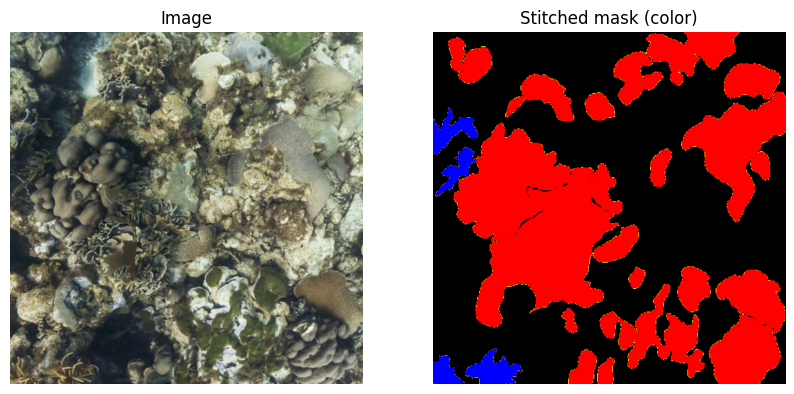

In [ ]:
batch = next(iter(train_loader))
imgs, masks, _ = batch

# show first sample
i = 1
img = imgs[i].permute(1,2,0).numpy()
mask = masks[i].permute(1,2,0).numpy().astype(np.uint8)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('Stitched mask (color)')
plt.axis('off')
plt.show()

## 8) (Optional) Convert color mask to class indices for training

In [ ]:
imgs_b, masks_b, metas_b = next(iter(train_loader))
idx_mask = color_mask_to_index(masks_b[0])  # [H, W] long
print("Index mask shape:", idx_mask.shape, "unique classes:", torch.unique(idx_mask))

Index mask shape: torch.Size([512, 512]) unique classes: tensor([0, 1, 2])


## 9) Quick dataset stats

In [ ]:
total = len(dataset)
paired = sum(1 for _ in dataset)  # counts items; if missing masks were dropped, this is equal to len
print(f"Total pairs (usable): {paired}/{total}")

# Resolution stats (sampled)
heights, widths = [], []
for k in range(min(200, len(dataset))):
    _, _, meta = dataset[k]
    img = Image.open(meta['image_path']).convert('RGB')
    w, h = img.size
    widths.append(w); heights.append(h)

print("Sampled image size stats:")
print(" - mean WxH:", int(np.mean(widths)), "x", int(np.mean(heights)))
print(" - min WxH:", np.min(widths), "x", np.min(heights))
print(" - max WxH:", np.max(widths), "x", np.max(heights))

Total pairs (usable): 659/659
Sampled image size stats:
 - mean WxH: 1157 x 1157
 - min WxH: 868 x 868
 - max WxH: 2375 x 2375



## 10) Using the DataLoader in training

Below is a tiny template for how you'd iterate batches during model training (replace `your_model` and loss accordingly).


In [ ]:
# Pseudo-training loop (skeleton)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

# your_model = ...
# your_model.to(device)
# optimizer = torch.optim.Adam(your_model.parameters(), lr=1e-3)
# criterion = ...  # e.g., CrossEntropyLoss for class index masks

for epoch in range(1):
    # Train
    # your_model.train()
    for imgs, masks, _ in train_loader:
        imgs = imgs.to(device)
        # Convert color mask to indices if using a segmentation criterion expecting classes
        idx_masks = torch.stack([color_mask_to_index(m) for m in masks]).to(device)  # [B, H, W]
        # logits = your_model(imgs)  # [B, C, H, W]
        # loss = criterion(logits, idx_masks)
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        pass

    # Validate
    # your_model.eval()
    # with torch.no_grad():
    #     for imgs, masks, _ in val_loader:
    #         ...

print("DataLoader is ready for integration with your training code.")

# Baseline model for coral segmentation
Here is a pretrained U-Net model on a random subset of 100 images and corresponding masks for 20 epochs.

When you decide to use this code and Google Colab for model training, make sure to connect to GPU. You can change your runtime type in the top left menu.

Runtime > Change runtime type > T4 GPU

In [ ]:
!pip install -q segmentation-models-pytorch
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 21.9 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import MulticlassJaccardIndex
import segmentation_models_pytorch as smp

In [ ]:
# Replace the simple model with a pretrained U-Net
# Choose a suitable encoder (e.g., 'resnet34')
# num_classes should be the number of classes in your dataset (len(COLOR_TO_CLASS) + 1 for background)
model = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. resnet34 or efficientnet-b0
    encoder_weights="imagenet",     # use imagenet pretrained weights
    in_channels=3,                  # model input channels (images are RGB)
    classes=len(COLOR_TO_CLASS) + 1, # model output channels (number of segmentation classes)
)

# Print the model architecture
print(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# Pseudo-training loop (skeleton)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

# Move the model to the selected device
model.to(device)

# Define the loss function (CrossEntropyLoss for segmentation)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Training loop configuration (device, loss, optimizer) is ready for the U-Net model.")

Device: cuda
Training loop configuration (device, loss, optimizer) is ready for the U-Net model.


In [ ]:
# Set the number of training epochs
num_epochs = 20

print(f"Starting training for {num_epochs} epochs on {device}")

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    running_loss = 0.0
    # Use tqdm for a progress bar
    for i, (imgs, masks, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # Move images and masks to the selected device
        imgs = imgs.to(device)
        # Convert color mask to indices and stack them
        idx_masks = torch.stack([color_mask_to_index(m.cpu()) for m in masks]).to(device)  # [B, H, W]

        # Pass images through the model to get predicted logits
        logits = model(imgs)  # [B, C, H, W]

        # Calculate the loss
        loss = criterion(logits, idx_masks)

        # Perform a backward pass to calculate gradients
        loss.backward()

        # Update the model's weights
        optimizer.step()

        # Zero the optimizer's gradients
        optimizer.zero_grad()

        running_loss += loss.item()

    # Print loss for each epoch
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

print("Training finished.")

Starting training for 20 epochs on cuda


Epoch 1/20: 100%|██████████| 149/149 [00:50<00:00,  2.94it/s]


Epoch [1/20], Average Loss: 0.4900


Epoch 2/20: 100%|██████████| 149/149 [00:41<00:00,  3.57it/s]


Epoch [2/20], Average Loss: 0.3814


Epoch 3/20: 100%|██████████| 149/149 [00:43<00:00,  3.46it/s]


Epoch [3/20], Average Loss: 0.3431


Epoch 4/20: 100%|██████████| 149/149 [00:40<00:00,  3.65it/s]


Epoch [4/20], Average Loss: 0.3329


Epoch 5/20: 100%|██████████| 149/149 [00:41<00:00,  3.60it/s]


Epoch [5/20], Average Loss: 0.3121


Epoch 6/20: 100%|██████████| 149/149 [00:41<00:00,  3.62it/s]


Epoch [6/20], Average Loss: 0.2873


Epoch 7/20: 100%|██████████| 149/149 [00:42<00:00,  3.51it/s]


Epoch [7/20], Average Loss: 0.2833


Epoch 8/20: 100%|██████████| 149/149 [00:41<00:00,  3.61it/s]


Epoch [8/20], Average Loss: 0.2655


Epoch 9/20: 100%|██████████| 149/149 [00:40<00:00,  3.66it/s]


Epoch [9/20], Average Loss: 0.2456


Epoch 10/20: 100%|██████████| 149/149 [00:42<00:00,  3.53it/s]


Epoch [10/20], Average Loss: 0.2334


Epoch 11/20: 100%|██████████| 149/149 [00:41<00:00,  3.58it/s]


Epoch [11/20], Average Loss: 0.2460


Epoch 12/20: 100%|██████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch [12/20], Average Loss: 0.2102


Epoch 13/20: 100%|██████████| 149/149 [00:41<00:00,  3.59it/s]


Epoch [13/20], Average Loss: 0.1849


Epoch 14/20: 100%|██████████| 149/149 [00:41<00:00,  3.60it/s]


Epoch [14/20], Average Loss: 0.1704


Epoch 15/20: 100%|██████████| 149/149 [00:42<00:00,  3.54it/s]


Epoch [15/20], Average Loss: 0.1667


Epoch 16/20: 100%|██████████| 149/149 [00:42<00:00,  3.52it/s]


Epoch [16/20], Average Loss: 0.2058


Epoch 17/20: 100%|██████████| 149/149 [00:41<00:00,  3.56it/s]


Epoch [17/20], Average Loss: 0.1783


Epoch 18/20: 100%|██████████| 149/149 [00:43<00:00,  3.46it/s]


Epoch [18/20], Average Loss: 0.1531


Epoch 19/20: 100%|██████████| 149/149 [00:41<00:00,  3.59it/s]


Epoch [19/20], Average Loss: 0.1298


Epoch 20/20: 100%|██████████| 149/149 [00:48<00:00,  3.09it/s]

Epoch [20/20], Average Loss: 0.1240
Training finished.


In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store true and predicted masks
all_true_masks = []
all_pred_masks = []

print("Starting validation for U-Net model...")

# Disable gradient calculation for evaluation
with torch.no_grad():
    for imgs, masks, _ in tqdm(val_loader, desc="Evaluating U-Net"):
        # Move images to the selected device
        imgs = imgs.to(device)

        # Pass images through the model to get predicted logits
        logits = model(imgs)  # [B, C, H, W]

        # Apply softmax to get class probabilities and determine predicted class
        probs = F.softmax(logits, dim=1) # [B, C, H, W]
        predicted_masks = torch.argmax(probs, dim=1) # [B, H, W]

        # Convert color mask to index masks
        true_masks_indices = torch.stack([color_mask_to_index(m.cpu()) for m in masks]).to(device) # [B, H, W]

        # Append true and predicted masks to lists
        all_true_masks.append(true_masks_indices)
        all_pred_masks.append(predicted_masks)

# Concatenate or stack the stored masks
all_true_masks = torch.cat(all_true_masks, dim=0)
all_pred_masks = torch.cat(all_pred_masks, dim=0)

print("Validation finished. Calculating metrics...")

# Calculate IoU metrics
# Assuming the classes are 0, 1, 2 based on the previous output
num_classes = len(COLOR_TO_CLASS) + 1 # Add 1 for background class (class 0)
iou_metric = MulticlassJaccardIndex(num_classes=num_classes, average=None, ignore_index=None).to(device) # Calculate IoU for each class
mean_iou_metric = MulticlassJaccardIndex(num_classes=num_classes, average='macro', ignore_index=None).to(device) # Calculate mean IoU

per_class_iou = iou_metric(all_pred_masks, all_true_masks)
mean_iou = mean_iou_metric(all_pred_masks, all_true_masks)

# Print the calculated IoU metrics
print(f"Per-class IoU: {per_class_iou}")
print(f"Mean IoU: {mean_iou.item():.4f}")

# Note: mAP is typically for object detection. For semantic segmentation, IoU is the standard metric.
# We will not calculate mAP unless a specific definition for segmentation mAP is provided.

Starting validation for U-Net model...


Evaluating U-Net: 100%|██████████| 17/17 [00:03<00:00,  4.83it/s]


Validation finished. Calculating metrics...
Per-class IoU: tensor([0.9023, 0.5324, 0.6148], device='cuda:0')
Mean IoU: 0.6832


Visualizing a batch of results from the validation set for the U-Net model:


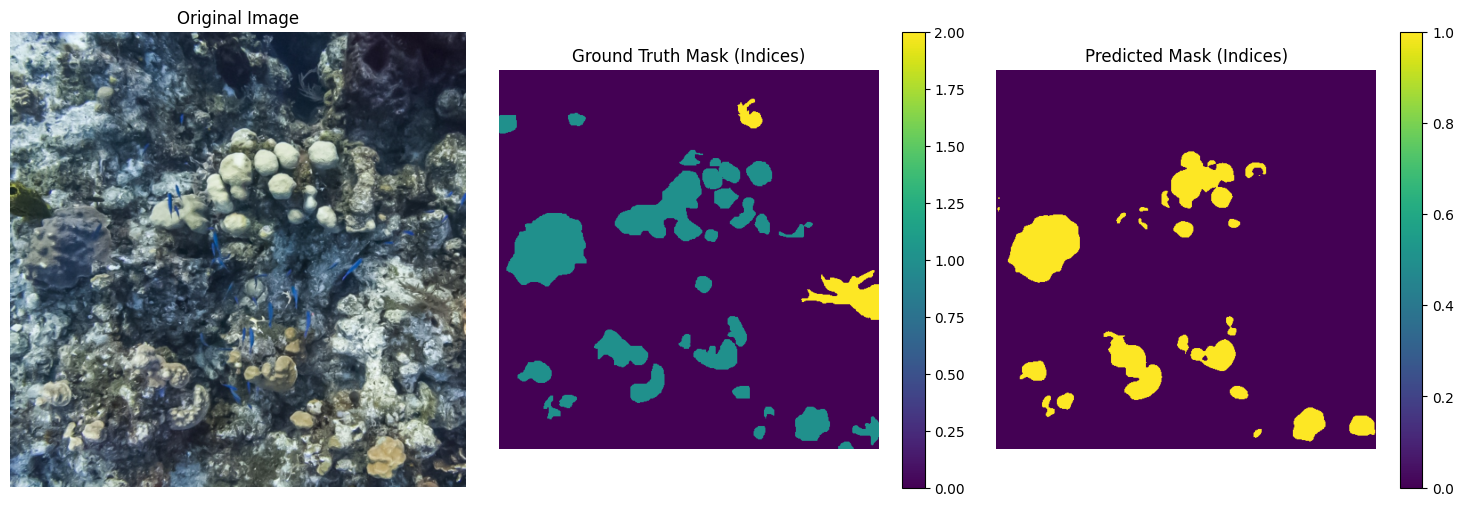

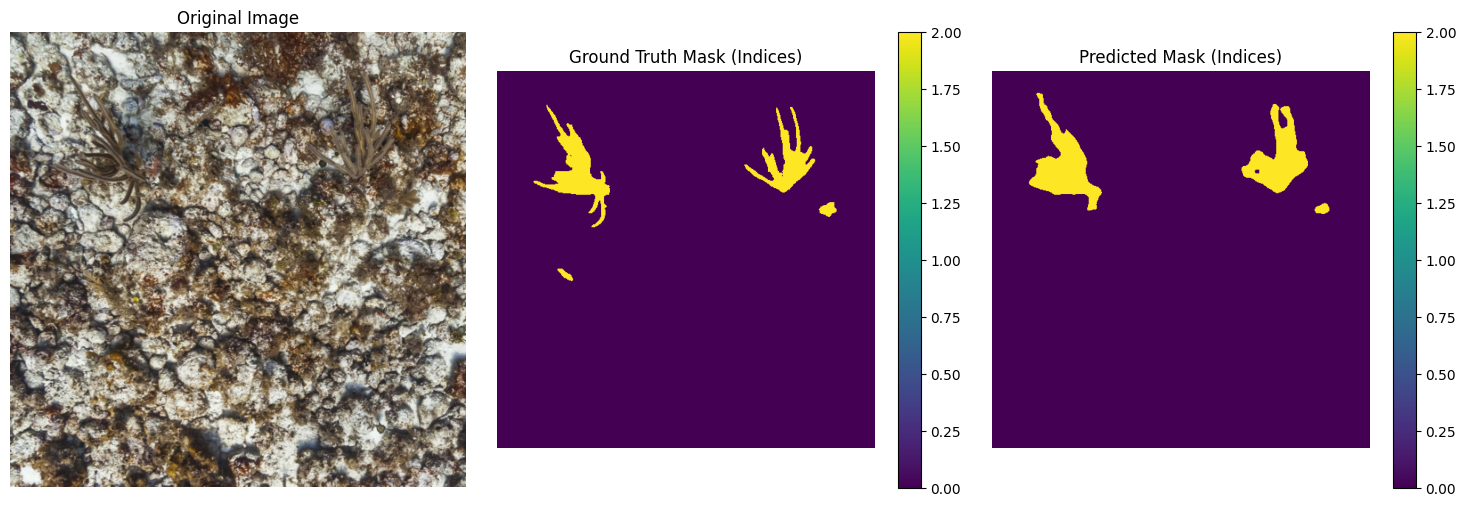

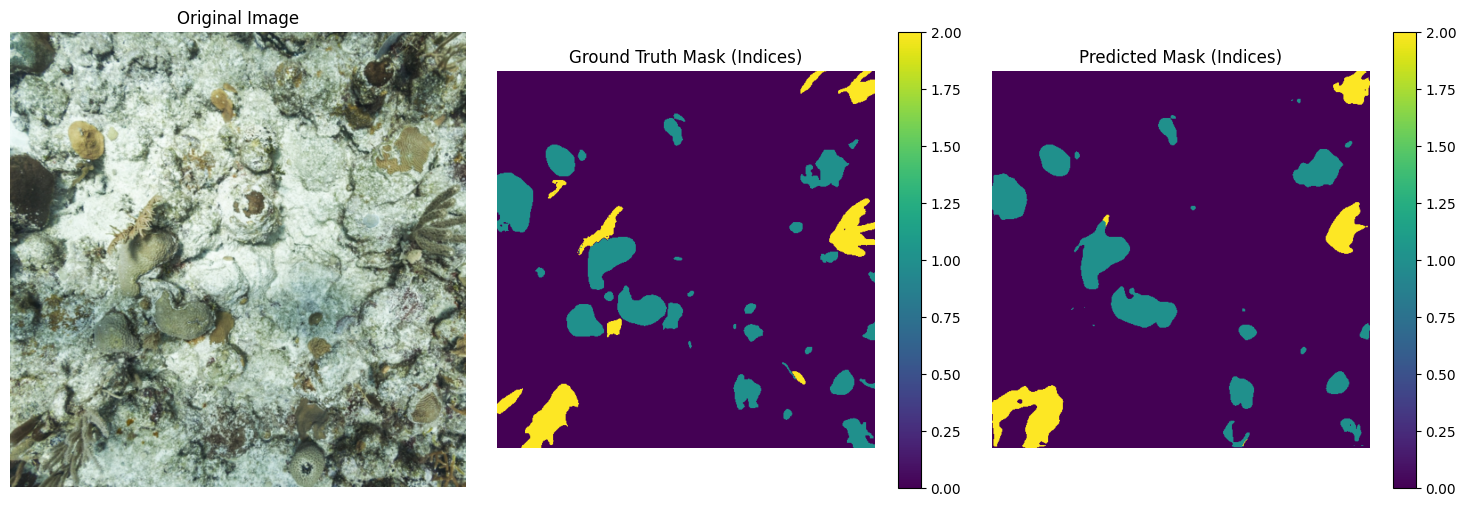

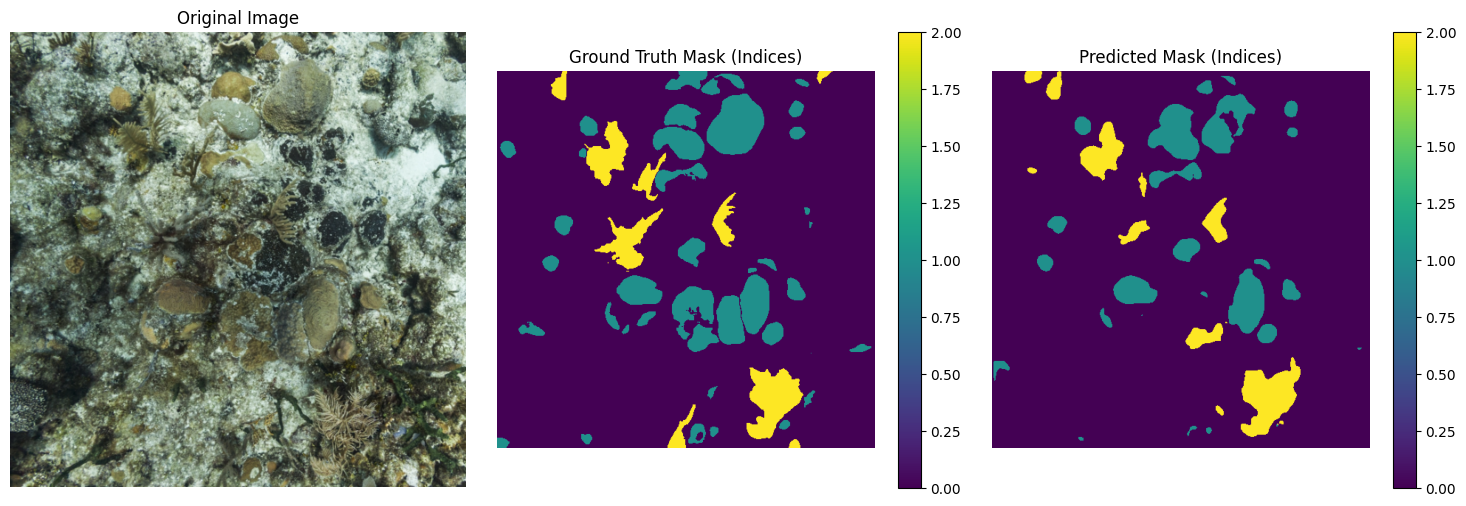

In [ ]:
# Visualize a batch of results for the U-Net model
print("Visualizing a batch of results from the validation set for the U-Net model:")

# Get a batch from the validation loader
images_batch, masks_batch, _ = next(iter(val_loader))

# Move images to the device and get predictions
images_batch = images_batch.to(device)
with torch.no_grad():
    logits = model(images_batch)
    probs = F.softmax(logits, dim=1)
    predicted_masks_batch = torch.argmax(probs, dim=1) # [B, H, W]

# Move masks back to CPU for visualization if they are on GPU
images_batch_cpu = images_batch.cpu()
masks_batch_cpu = masks_batch.cpu()
predicted_masks_batch_cpu = predicted_masks_batch.cpu()

# Convert color masks to index masks for ground truth
ground_truth_index_masks_batch = torch.stack([color_mask_to_index(m.cpu()) for m in masks_batch_cpu])

# Visualize each item in the batch
for i in range(images_batch_cpu.shape[0]):
    img = images_batch_cpu[i].permute(1, 2, 0).numpy()
    ground_truth_mask = ground_truth_index_masks_batch[i].numpy()
    predicted_mask = predicted_masks_batch_cpu[i].numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display ground truth mask
    # We can use a colormap to visualize the index masks
    im1 = axes[1].imshow(ground_truth_mask, cmap='viridis')
    axes[1].set_title('Ground Truth Mask (Indices)')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1])

    # Display predicted mask
    im2 = axes[2].imshow(predicted_mask, cmap='viridis')
    axes[2].set_title('Predicted Mask (Indices)')
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2])


    plt.tight_layout()
    plt.show()